This notebook serves as a compilation of code I've written to experiment with regression using polynomials and frames.

To run this code, one must install numpy, matplotlib, and zernike packages.
These can all be acquired using pip install.

This notebook includes specific instruction to examine regression on lines, squares, annuli, and disks, but also has a general function that can test regression on any domain, such as tensor products of annuli or disks.

In these sections, there will also be specific results demonstrating where polynomial frames outperfrorm legendre bases, and the code for how to replicate them.

See sections below for more thurough documentation.

Also just ask if you have any questions

In [ ]:
!pip install zernike

In [ ]:
#imports

import numpy as np
import numpy.linalg as la
import math
import random
import matplotlib.pyplot as plt
import concurrent.futures as pool
from zernike import RZern

In [ ]:
#basic auxiliary functions, used as helper functions

def ftrl(n):   #factorial function extended to decimals
  return math.gamma(n+1)

def ncr(n,r):   #choose function extended to decimals
  return ftrl(n)/ftrl(r)/ftrl(n-r)

def randptsnd(dim,n,a,b):  #generates n^dim randomly located points on dimentions given by list a and list b
  return np.array([[random.uniform(a[x],b[x]) for i in range(n**dim)] for x in range(dim)])

def eqptsnd(dim,n,a,b):  #generates n**dim equispaced points on bounds set by a and b
  xpts = []
  for d in range(dim):
    spread = np.linspace(a[d],b[d],n)
    total = []
    for x in spread:
      total.extend([x]*n**d)
    xpts.append(total*(n**(dim-d-1)))
  return np.array(xpts)


def evalnd(dim,x,bases,coeffs,degrees,gammas): #evalues a function at list of coords x all basises must be same order
  evals = []
  if gammas[0] == 0:
    tensorevals = bases[0](x[0],degrees[0])
  else:
    tensorevals = bases[0](x[0],degrees[0],gammas[0])

  for d in range(1,dim):
    if gammas[d] == 0:
      evals = bases[d](x[d],degrees[d])
    else:
      evals = bases[d](x[d],degrees[d],gammas[d])
    tensorevals = np.tensordot(tensorevals,evals,0)

  return np.tensordot(tensorevals.reshape(degreeproduct(degrees)),coeffs,1)

def multievalnd(dim,xpts,bases,coeffs,degrees,gammas):     #multiple eval functions
  return np.array([evalnd(dim,xpts[:,i],bases,coeffs,degrees,gammas) for i in range(len(xpts[0]))])

def avgerrornd(dim,xpts,ypts,bases,coeffs,degrees,gammas): #average error for n dimensional function
  evals = multievalnd(dim,xpts,bases,coeffs,degrees,gammas)
  return np.mean(abs(evals-ypts))

def degreeproduct(degrees):  #helper function for reshaping tensor products into design matrix form
  product = 1
  for degree in degrees:
    product *= (degree+1)
  return product

In [ ]:
#evaluation matrix functions


def evalmtrxnd(dim,xpts,bases,degrees,gammas):   #generates a design matrix
  mtrx = []
  for i in range(len(xpts[0])):
    if gammas[0] == 0:
      tensorevals = bases[0](xpts[0][i],degrees[0])
    else:
      tensorevals = bases[0](xpts[0][i],degrees[0],gammas[0])

    for d in range(1,dim):
      if gammas[d] == 0:
        tensorevals = np.tensordot(tensorevals,bases[d](xpts[d][i],degrees[d]),0)
      else:
        tensorevals = np.tensordot(tensorevals,bases[d](xpts[d][i],degrees[d],gammas[d]),0)

    mtrx.append(tensorevals.reshape(degreeproduct(degrees)))
  return np.array(mtrx)


In [ ]:
def legcreate(degree):   #creates a matrix for quickly evaluating legendre

  legendre = np.array([[0.0 for b in range(degree+1)] for a in range(degree+1)])
  for row in range(degree+1):
    for col in range(degree+1):
      if col > row:
        legendre[row][col] = 0.0
      elif (row+col)%2 != 0:
        legendre[row][col] = 0.0
      else:
        legendre[row][col] = 2**row * ncr(row,col) * ncr((row+col-1)/2.0,row)

  return legendre

def framecreate(degree,gamma): #creates a matrix for quicly evaluating legendre frames

  legendre = np.array([[0.0 for b in range(degree+1)] for a in range(degree+1)])
  for row in range(degree+1):
    for col in range(degree+1):
      if col > row:
        legendre[row][col] = 0.0
      elif (row+col)%2 != 0:
        legendre[row][col] = 0.0
      else:
        legendre[row][col] = 2**row * ncr(row,col) * ncr((row+col-1)/2.0,row) / gamma**col * np.sqrt(row+0.5) / np.sqrt(gamma)

  return legendre

In [ ]:
#fit functions

def lstsqfitnd(dim,xpts,ypts,bases,degrees,gammas):  #fit in dim dimensions
  mtrx = evalmtrxnd(dim,xpts,bases,degrees,gammas)
  coeffs, b, c, d = la.lstsq(mtrx,ypts)
  return coeffs

#NOTE: graphs currently use lstsqfitnd as their regression function, this uses la.lstsq to perform regression


In [ ]:
def do_regressionnd(dim,bases,gammas,degrees,npts,currpts,a,b,interp,c,random):
  errpts = randptsnd(dim,npts,a,b)
  if (random):
    pts = randptsnd(dim,currpts,a,b)
  else:
    pts = eqptsnd(dim,currpts,a,b)
  #print("executing " + str(currpts))

  coeffs = lstsqfitnd(dim,pts,interp(pts,c),bases,degrees,gammas)
  error = avgerrornd(dim,errpts,interp(errpts,c),bases,coeffs,degrees,gammas)
  #print("done" + str(currpts))
  return error


def graphnd(n,dim,bases,gammas,a,b,degrees,npts,interp,c,random,workers,labels,title):
  errors = [[0.0]*(npts-max(degrees)) for x in range(n)]
  pointnums = [x**dim for x in range(max(degrees)+1,npts+1)]

  with pool.ThreadPoolExecutor(max_workers=workers) as executor:
    vals = []
    for x in range(n):
      vals.append({executor.submit(do_regressionnd,dim,bases[x],gammas[x],degrees,npts,currpts,a,b,interp,c,random) : currpts for currpts in range(max(degrees)+1,npts+1)})

    for x in range(n):
      for val in pool.as_completed(vals[x]):
        ind = vals[x][val] - max(degrees) - 1
        errors[x][ind] = val.result()

  plt.yscale("log")
  for x in range(n):
    plt.plot(pointnums,errors[x],label=labels[x])
  plt.title(title)
  plt.ylabel("error")
  plt.xlabel("sample number")
  plt.legend()
  plt.show()

The section below contains basis functions. currently implimented are:
- legendre basis
- legendre frame (normalised)
- periodic basis function: a progression of sinusoidal functions for use on angular coordinates
- zernike polynomials and frames for regression on a disk

In [ ]:
def legframe(x,degree,gamma):  #legendre polynomial frame
  xpwrs = np.array([x**n for n in range(degree+1)])
  if gamma in framedaddy:
    return framedaddy[gamma][:degree+1,:degree+1] @ xpwrs
  else:
    return framecreate(degree,gamma) @ xpwrs

def legendre(x,degree):    #generates a row of legendre polynomials evaluated at x
  global legdaddy
  xpwrs = np.array([x**n for n in range(degree+1)])
  return legdaddy[:degree+1,:degree+1] @ xpwrs

def leftframe(x,degree,gamma): #left sided frame
  stretch = (gamma + 1.0) / 2
  shift = (gamma - 1.0) / 2
  return legframe(x+shift,degree,stretch)

def rightframe(x,degree,gamma): #stretches on right side
  stretch = (gamma + 1.0) / 2
  shift = (gamma - 1.0) / 2
  return legframe(x-shift,degree,stretch)

def periodic(x,degree):  #generates the n'th function in the sin cos progression, evaluated at x
  return np.array([n%2*np.sin((n+1)//2*x) + (n+1)%2*np.cos(n/2*x) for n in range(degree+1)])

def radzern(x,degree):    #radial component of the zernike
  return np.array([zern.radial(n,x) for n in range(degree+1)])

#Note: zernframe assumes that the disk has radius 1 and centered at 0.

def zernframe(x,degree,gamma):     #frame of radial component zernike
  return np.array([zern.radial(n,x/gamma+0.5*(1-1.0/gamma)) for n in range(degree+1)])

def zernframe2(x,degree,gamma):     #old version of zernike frame, which only stretched on one side.
  return np.array([zern.radial(n,x/gamma) for n in range(degree+1)])

def angzern(x,degree):    #angular component of zernike
  return np.array([zern.angular(n,x) for n in range(degree+1)])

The section below is for writing the function that you want to interpolate, most prior experimentatin has been done using the witch of agnesi, but the frames seem to beat bases with many reasonable function.

In [ ]:
#functions should take a list of parameters and a list of constant values.
#for n-dimensional domains pts should have length n

def witchhat1d(pts,c):   #1 dimension witch hat
  return 1 / (1 + pts[0]**2*c[0]**2)

def witchhat2d(pts,c):   #2 dimension witch hat
  return 1 / (1 + pts[0]**2*(c[0]**2 + pts[1]**2))

def witchhatannulus(pts,c):  #hat on annulus, pts in the form [r,theta]
  return 1 / (1 + c[0]**2*(pts[0]**2 + np.sin(pts[1])**2))

def pringle(pts,c):   #function on disk or annulus to mimic witch hat
    return 1 / (1 + c[0]**2*pts[0]**2*np.cos(pts[1])**2)

def diskbump(pts,c):   #function on disk that only uses radial component
    return c[0]*np.cos(pts[0])

def gbump(pts,c):   #gaussian bump function on a disk, also only uses radial component
  return np.exp(-1*c[0]*pts[0]**2)

def tensorannulifn(pts,c):  #function of a tensor product of annuli
  return 1/ (1 + pts[0]**2 + pts[1]**2 + np.sin(pts[2])**2 + np.sin(pts[3])**2)

In [ ]:
#pre-processing legendre funcitons to help improve performance

legdaddy = legcreate(100)
framedaddy = {}
for x in [n/10.0 for n in range(10,101)]:
  framedaddy[x] = framecreate(100,x)

#required zernike pre-processing

zern = RZern(60)

The next few cells contain example calls to the graphnd function which compares the performance of bases vs. frames. The graphs below are just for demonstration purposes, and have total degree 20. For the frame to do better than the basis, a degree of 35+ for each basis function is needed. Most of my tests were done using a degree of 60 for each basis function.

<ipython-input-13-33b04ed4c618>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, b, c, d = la.lstsq(mtrx,ypts)


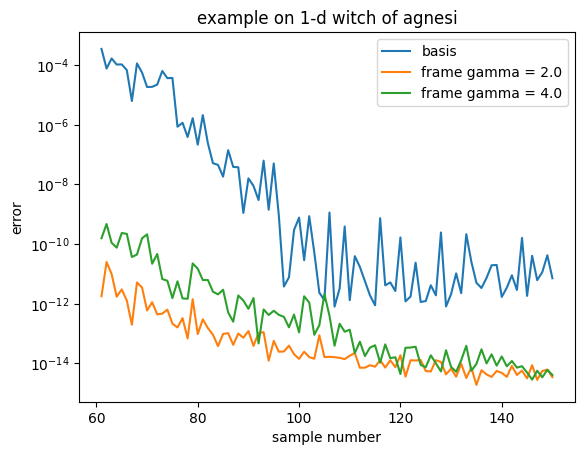

In [ ]:
#example one-dimensional call:

def samplegraph():
  #the number of functions to graph
  n = 3

  #the dimension of the domain, eg 1 for a line, 2 for a square or disk
  dim = 1

  #a two dimensional list of basis functions. len(bases) must equal n, and len(bases[0]) must equal dim
  bases = [[legendre],[legframe],[legframe]]

  #a two dimensional list of values for gamma, set gamma value for basis functions that do not accept a gamma to 0
  gammas = [[0],[2.0],[1.5]]

  #a list of the left side boundary of domain, for each dimension
  a = [-1]

  #a list of the right side boundary of domain, for each dimension
  b = [1]

  #a list of the max degree to be used for basis functions, for each dimension
  degrees = [60]

  #an integer referring to the maximum number of datapoints to test on the graph
  npts = 150

  #the function we want to approximate
  interp = witchhat1d

  #a list of constants to pass to interp
  c = [1.0]

  #a boolean, true causes program to use randomly spaced points, falses uses equispaced points
  userandom = False

  #an integer for the number of threads to use when running asynchronously, increasing likely will not improve performance on computers
  workers = 1

  #a list of strings to label each line in the graph
  labels = ["basis","frame gamma = 2.0", "frame gamma = 4.0"]

  #graph title, a string
  title = "example on 1-d witch of agnesi"

  graphnd(n,dim,bases,gammas,a,b,degrees,npts,interp,c,userandom,workers,labels,title)

samplegraph()

<ipython-input-13-33b04ed4c618>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, b, c, d = la.lstsq(mtrx,ypts)


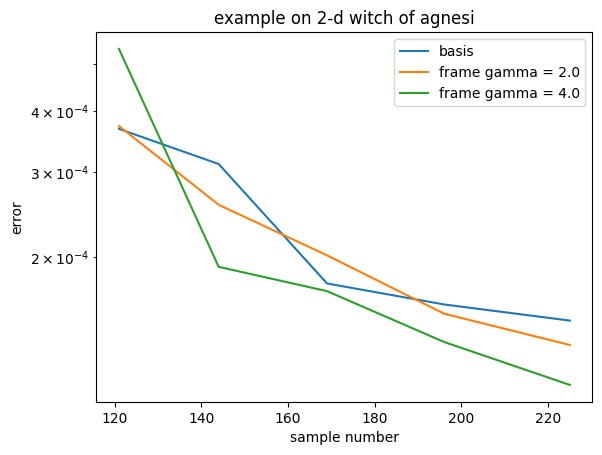

In [ ]:
#another example, this one is in 2d on a square

def samplegraph2d():

  n = 3
  dim = 2
  bases = [[legendre,legendre],[legframe,legframe],[legframe,legframe]]
  gammas = [[0,0],[2.0,2.0],[4.0,4.0]]
  a = [-1,-1]
  b = [1,1]
  degrees = [10,10]
  npts = 15
  interp = witchhat2d
  c = [1.0,1.0]
  userandom = False
  workers = 1
  labels = ["basis","frame gamma = 2.0", "frame gamma = 4.0"]
  title = "example on 2-d witch of agnesi"

  graphnd(n,dim,bases,gammas,a,b,degrees,npts,interp,c,userandom,workers,labels,title)

samplegraph2d()

<ipython-input-13-33b04ed4c618>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, b, c, d = la.lstsq(mtrx,ypts)


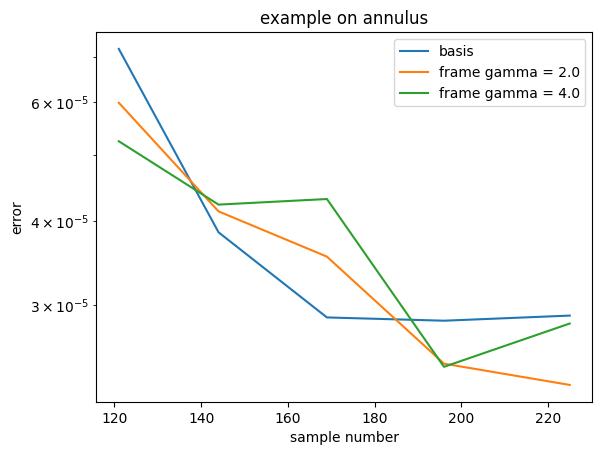

In [ ]:
#example on an annulus, using polar coordinates periodic functions for the angular component, and legendre bases or frames for the radial component:

def samplegraphann():

  n = 3
  dim = 2
  bases = [[legendre,periodic],[legframe,periodic],[legframe,periodic]]
  gammas = [[0,0],[2.0,0],[4.0,0]]
  a = [0.5,0]
  b = [1,math.pi]
  degrees = [10,10]
  npts = 15
  interp = witchhatannulus
  c = [1.0,1.0]
  userandom = False
  workers = 1
  labels = ["basis","frame gamma = 2.0", "frame gamma = 4.0"]
  title = "example on annulus"

  graphnd(n,dim,bases,gammas,a,b,degrees,npts,interp,c,userandom,workers,labels,title)

samplegraphann()

<ipython-input-13-33b04ed4c618>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, b, c, d = la.lstsq(mtrx,ypts)


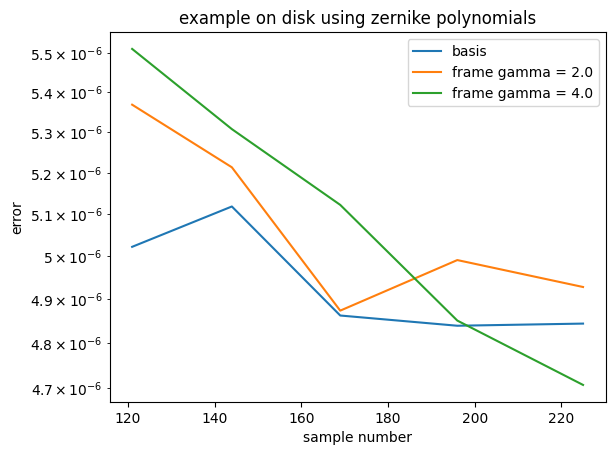

In [ ]:
#example on a disks, using zernike polynomials and frames.

def samplegraphdisk():

  n = 3
  dim = 2
  bases = [[radzern,angzern],[zernframe,angzern],[zernframe2,angzern]]
  gammas = [[0,0],[2.0,0],[2.0,0]]
  a = [0,0]
  b = [1,math.pi]
  degrees = [10,10]
  npts = 15
  interp = diskbump
  c = [1.0,1.0]
  userandom = False
  workers = 1
  labels = ["basis","frame gamma = 2.0", "frame gamma = 4.0"]
  title = "example on disk using zernike polynomials"

  graphnd(n,dim,bases,gammas,a,b,degrees,npts,interp,c,userandom,workers,labels,title)

samplegraphdisk()

In [ ]:
#example of how to do something on a tensor product. This is a tensor product of annuli.

def samplegraphtensor():

  n = 2
  dim = 4
  bases = [[legendre,legendre,periodic,periodic],[legframe,legframe,periodic,periodic]]
  gammas = [[0,0,0,0],[2.0,2.0,0,0]]
  a = [0.5,0.5,0,0]
  b = [1,1,math.pi,math.pi]
  degrees = [5,5,5,5]
  npts = 10
  interp = tensorannulifn
  c = [1.0]
  userandom = False
  workers = 1
  labels = ["basis","frame gamma = 2.0"]
  title = "example on tensor product of 2 disks"

  graphnd(n,dim,bases,gammas,a,b,degrees,npts,interp,c,userandom,workers,labels,title)

samplegraphtensor()

<ipython-input-13-33b04ed4c618>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, b, c, d = la.lstsq(mtrx,ypts)


The next section Is a collection of graphs I've made, detailing the results I've found. To recreate the results, simply run the graphnd function using the specified degree and gamma for the graph, setting interp to the correct function pointer. The results will be split into different sections for various functions.


Note: The the code tests for accuracy on randomly selected points, so the results might not be exacly the same every time, but there should be very little difference.

#1 Dimension

Regressions were tested using degree 60 polynomials on the witchhat1d function, called the witch of agnesi, on the domain [-1,1]:

$f(x) = \frac{1}{1 + c^2x^2}$

As we increase c, the function becomes less and less analytic. When functions are very analytic, a value for gamma that is higher (closer to 4.0 in practice) tends to do better, and as functions become less analytic smaller gammas are the best. I've found that, at least for degree 60, using gamma = 2.0 is almost always close to the best choice. The value may change if a different degree polynomial is used instead.

It seems that as long as the functions are analytic enough for the degree of polynomial that we are using, a frame with gamma 2.0 should do better than the basis. As functions become less analytic, the difference in performance between the basis and the frame decreases, until the functions essentially perform the same. See the graphs below for reference.

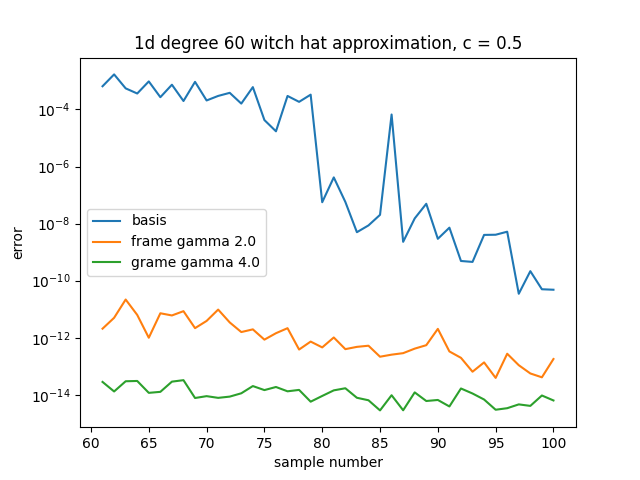

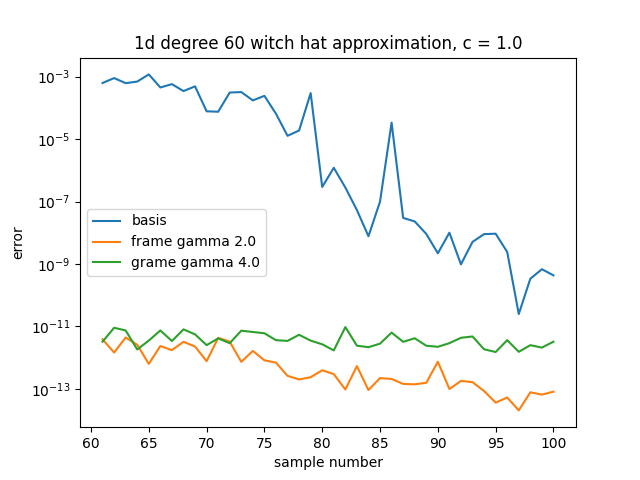

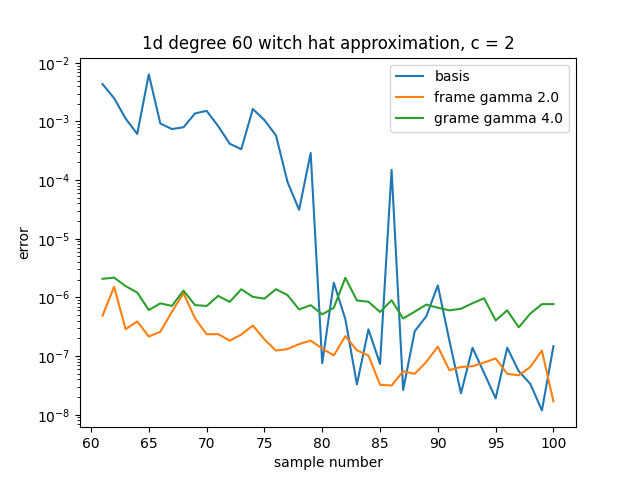

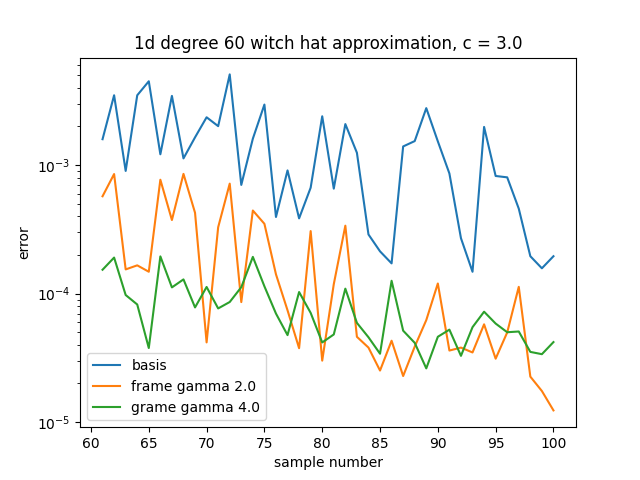

#Random Vs Equispaced points

Setting the "random" parameter of graphnd to True causes the program to perform the regression using randomly generated points instead of equispaced points. I tested whether this had any effect of the overall result of the function and it did not. The only difference was that there was a bit more variability in the error.

#Truncated SVD and Sweeps:

The la.lstsq function that was used for regression uses truncated svd to invert the design matrix, automatically choosing truncation cutoff ($\epsilon$), but one can experiment with choosing this value by hand, or by sweeping through a range of gammas and epsilons.

I experimented with a few methods of sweeps, which are as follows:

sweepfit: randomly split the given points in half, setting one half as training and the other half as validation. for each pair of gamma and epsilon that you want to try, do a regression on the training points, and then test the error on the validation points. take the gamma and epsilon with the best error, and use these to run a normal regression on all given data points.

sweepsmooth: This method was the same as sweepfit, but instead of randomly splitting the points, I sorted the points first, so that both training and validation sets were as evenly distributed as possible. In one dimension, this just meant that I sorted the points by position, and alternated putting them in training and validation sets.

sweepall: This method, instead of splitting into training and validation data, simply does both the training and valdation on the entire set of given points.

In practice, the sweepfit methods did better than a simple la.lstsq some of the time, but didn't do substantially better than using the auto-determined value for epsilon. I also noticed that the best value for gamma does not depend on the sample number at all. Thus, it is not necessary to perform more than one sweep. What I would recommend when tackling a new problem would be to do a sweep between 1.0 and 10.0, just to determine the best gamma to use, and not bother setting your own epsilon value.

See [this document](https://colab.research.google.com/drive/1SKhMgDwZV_gGOKMeZDtqZWBqikThpR1C?usp=sharing) for code that impliments sweeps in one dimension.

Note: This code is not very cleaned up.

#Envelopes and one sided frames

In one dimension, we tested one sided frames with envelopes to determine whether frames can still be effective when these changes are applied to them. To do a graph with a one-sided frame, call using the leftframe and rightframe functions.

These were tested on a shifted morse potential function:

$f(x) = (1 - e^{-c(x+1)})^2 - 1$

This function is difficult on the left side, close to -1, and is more analytic on the right side.

In this case, the one sided frames did show improvement over the basis, but not by as significant a margin as the two-sided frame was able to. The right sided frame seemed to do best with a gamma of around 5.0, and did better than the left-sided frame which did it's best with a gamma or around 9.0, and barely did better than the basis.

SEE [This document](https://colab.research.google.com/drive/12EEjenw6j1or9I4ncHTL_adCht0emBeF?usp=sharing) for many tests with different gammas.

I also tried applying an envelope function to the approximation, approximating using:

$f(x)≈ p_N(x)(x-1)(x+1)$

Approximations with and without this envelope seemed to do pretty much the same, and this is likely to be the case any time the envelope keeps things analytic.

See [this document](https://colab.research.google.com/drive/1svDUcg0CxEgZRWiWNCjou-5ahAH9qnci?usp=sharing) for tests using the envelope.

#Squares

The witch of agnesi can be extended to 2 dimensions using the witchhat2d function:

$f(x,y) = \frac{1}{1 + c^2(x^2 + y^2)}$

Once again, the constant c controls how analytic our function is.


Note: One can extend the witch hat function to cubes in any dimension, simply by using the function:

$f(x_1,...x_n) = \frac{1}{1 + c^2(x_1^2 + ... +x_n^2)}$

Below are graphs where polynomials from each basis has degree 60, giving a total degree of 120. As you can see, results on a square mimic results from one dimension, although slightly higher value of c is required to make the basis do as well as the frame.

#Typo:
some graph titles in this section say 1d, but should instead say square

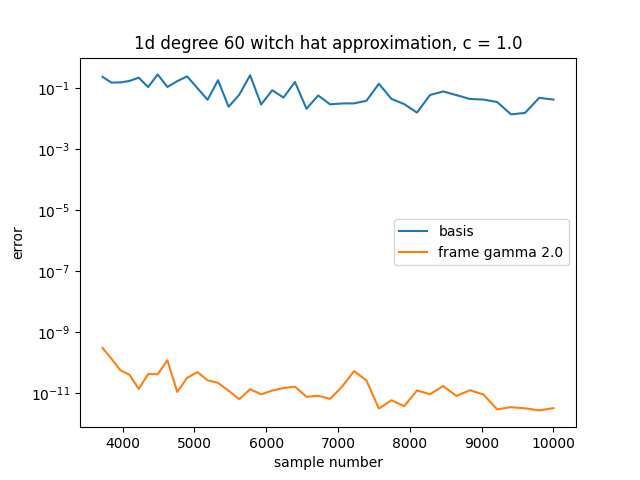

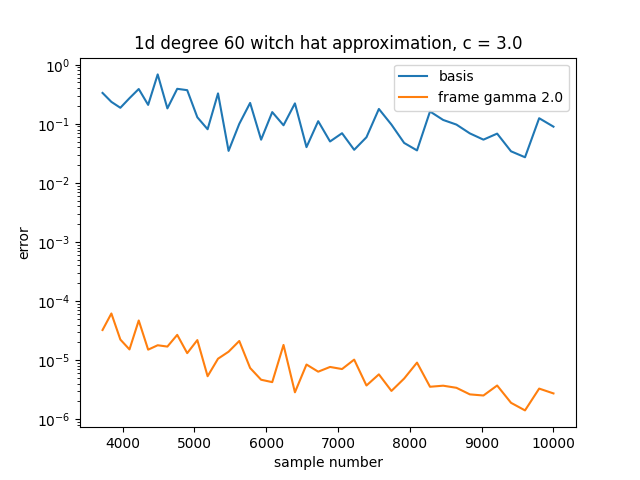

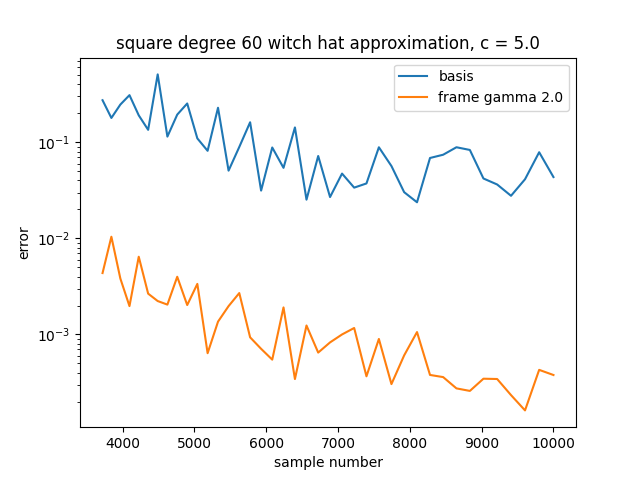

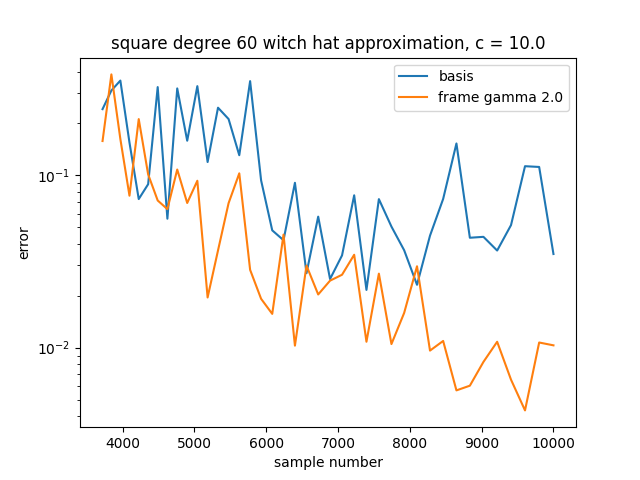

#Annuli

We approximate the annulus in polar coordinates, using a tensor product of legendre polynomials or frames in the radial component, and a series of sinusoidal functions (the periodic function in this code) in the angular component. The exact sinusoidal function that I used is:

$f_n(x) = \cos(\frac{nx}{2})$ if n is even, and \\
$f_n(x) = \sin(\frac{(n+1)x}{2})$ if n is odd

Thus generating an alternating sin,cos pattern with increasing frequency as n increases, and with $f_0(x) = 1$.

Results of graphing annuli seem to show that regardless of whether the function is difficult to approximate in the radial or angular direction, as long as it is analytic enough, the frame is able to do better. In this way, it seems to behave exactly the same as a square or line.

The graphs below were made using the witchhatannulus function:

$f(r,\theta) = \frac{1}{1 + c(r^2 + sin(\theta)^2)}$

Testing was done using the radial domain [0.1,1], but other domains could be used, as long as they start at a positive value. This function turned out to always be very analytic, as most of the complexity occurred outside the domain. Regardless, the functions perform more and more similarly as c increases.

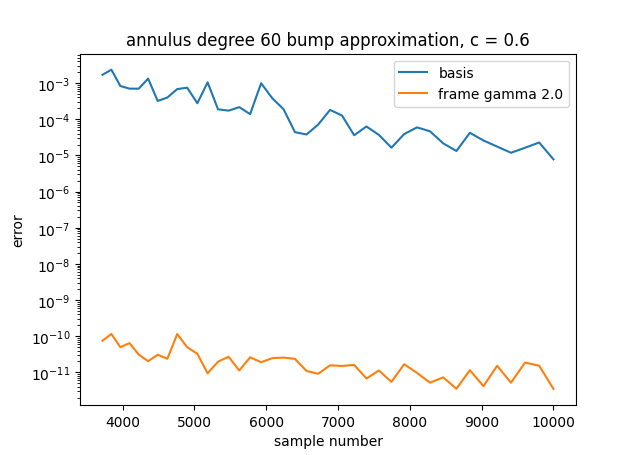

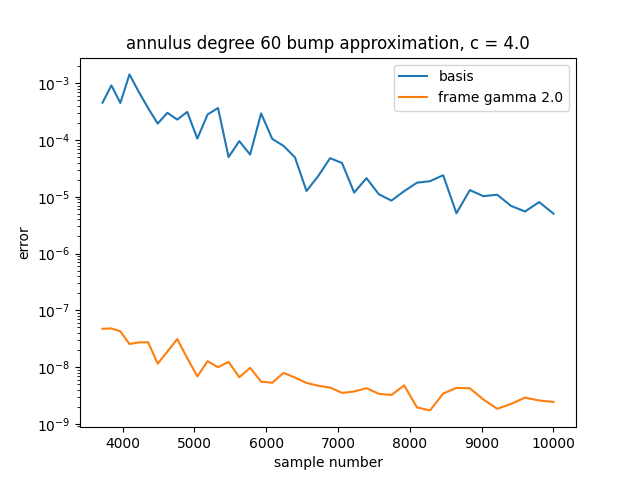

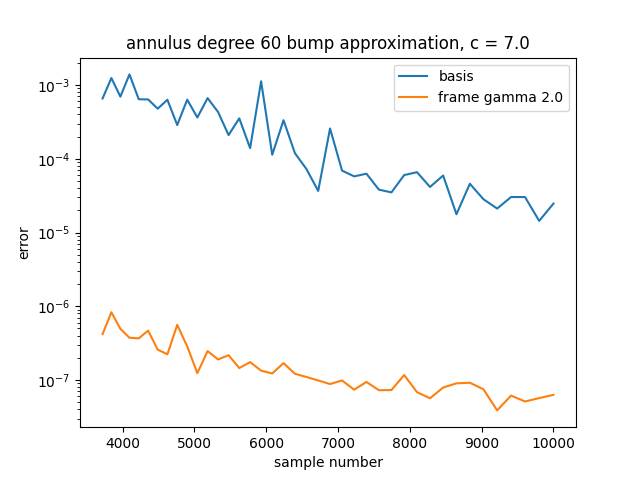

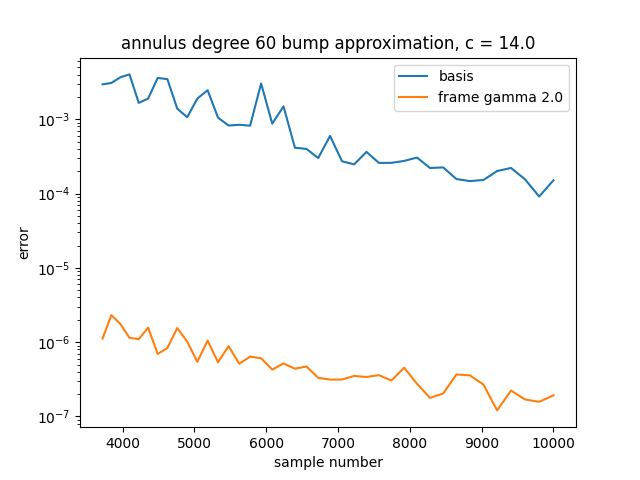

#Note on annuli

Even in a function that is constant in the radial direction, The frame still performs better than the basis. For example, the graph below interpolates the function:

$f(r,\theta) = \frac{1}{1 + \sin(\theta)^2}$

And the frame still does better.

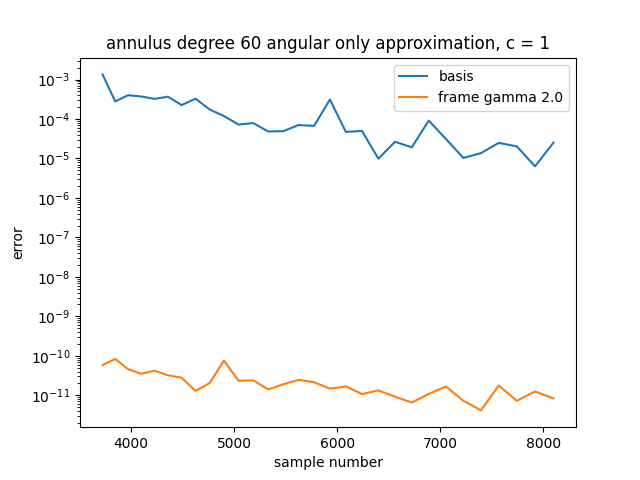

#Disks

Extending to a disk from an annulus requires switching from making frames on legendre polynomials to making them on zernike polynomials. As a first attempt at extending the zernike polynomials to a frame, I simply called the radial zernike function on x/gamma, to stretch the function out in the same way that a legendre frame would. Since the domain is [0,1] this would only stretch the function in one direction, so I also experimented with two other methods for creating the frame. These were a frame on [0,1] where I stretched and shifted so that it extends in both directions, and a frame where I changed the domain to [-1,1] in the radial component (and [0, $\pi$/2] in the angular component). Most testing was done using the second method, as all three methods performed roughly the same. I was unable to find a case where a frame performed significantly better than the basis.

A simple function to test on was the diskbump function:

$f(r,\theta) = c\cos(r)$

This function is very analytic and only complex in the radial component. Graphs below show tests for a range of gammas, form 1.5 to 10.0, but no value for gamma caused the frame to do better.

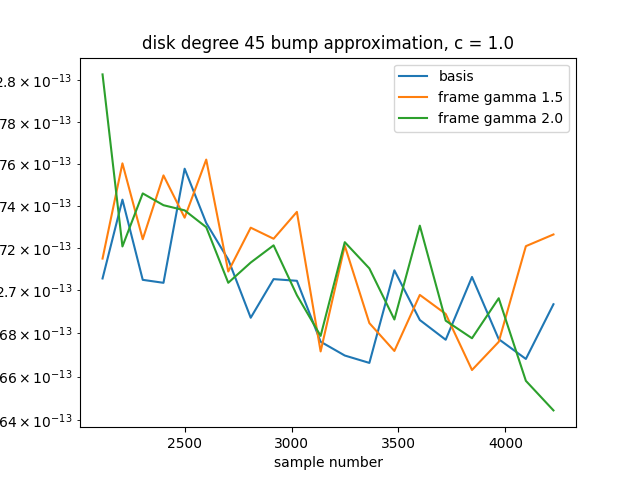

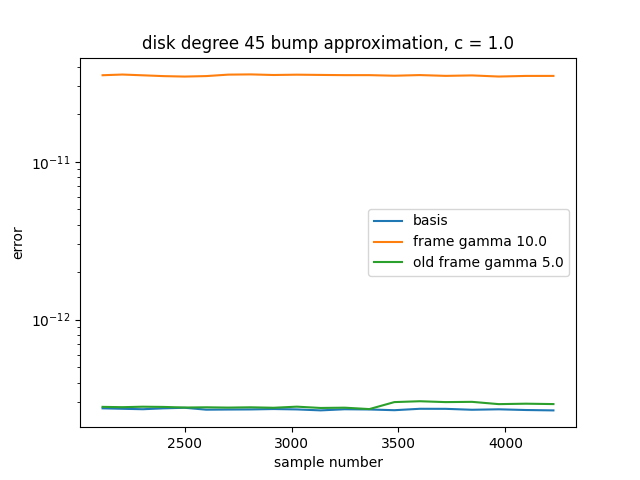

Most testing was done on the pringle function, a function that has complexity in both the radial and angular component, where one can adjust how analytic it is:

$f(r,\theta) = \frac{1}{1 + c^2r^2\cos(\theta)^2}$

Since this function is less analytic, the precision is less than it was on the diskbump function at $10^{-7}$ as opposed to $< 10^{-10}$, but both the basis and frame still perform equally here.

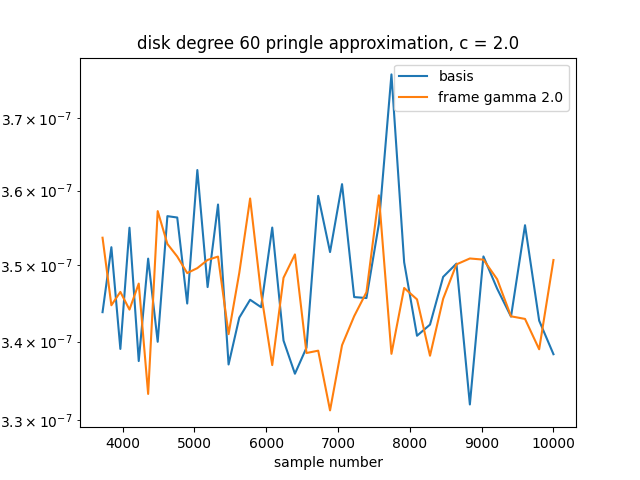

One Final thing that I tried was changing the distribution of points to an equispaced distribution. Previously, the distribution had points that were much more dense in the center of the disk. This change didn't seem to change the performance. Below is a graph made with the new distribution.

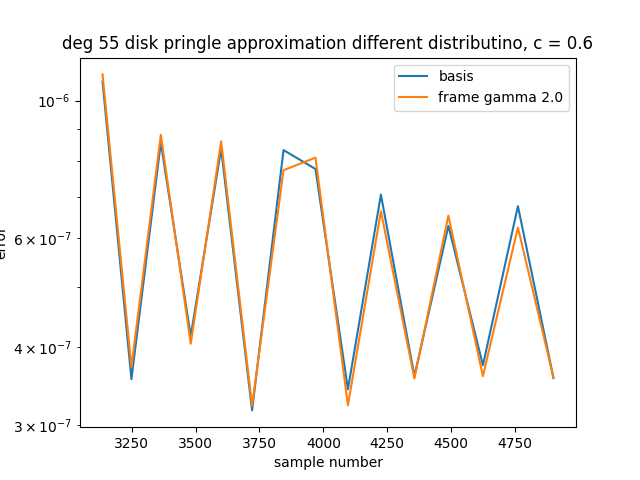

Note: One suggestion would be to try increasing the degree. This would be very computationally expensive, but it seems that as the degree increases, the difference between the basis and frame grows.

#Higher dimensions and tensor products

When we go part 2 dimensions, regressions become very computationally intensive, so there isn't much data here. The most difficult computation that python could handle within a reasonable amount of time would be something in four dimensions, with a degree of ~20 for each dimension. I would suggest migrating the code from python to something faster to do anything past this.

For cubes and hypercubes, the basis should do better than the frame in the same way that it would for a square, as long as the degree is high enough and the function is analytic enough.

Tensor products of annuli will likely work in the same way as a single annulus.

I have not looked into tensor products of disks at all, as I have yet to get the single disk case to work sucsessfully.